# Lab 1 - Understand NN and Training Process

## 1. Implement the following layers as Python functions (both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/AI_Lab1

In [1]:
import os
from typing import Callable, Iterable


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [3]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        self.x = x  # cache input for backward pass
        return np.dot(x, self.W.data) + self.b.data

    def backward(self, dy):
        self.W.grad = np.dot(self.x.T, dy)
        self.b.grad = np.sum(dy, axis=0, keepdims=True)  # sum over batch dimension
        dx = np.dot(dy, self.W.data.T)
        return dx

    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dy):
        dx = dy.copy()
        dx[self.x < 0] = 0
        return dx

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, dy):
        dx = dy * self.y * (1 - self.y)
        return dx

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # subtract max for numerical stability
        ex = np.exp(x - np.max(x, axis=-1, keepdims=True))
        self.y = ex / np.sum(ex, axis=-1, keepdims=True)
        return self.y

    def backward(self, dy):
        # Assume dy is coming from a cross-entropy loss
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [4]:
class MLP(Module):
    def __init__(self) -> None:
        self.fc1 = Linear(784, 512)
        self.relu1 = ReLU()
        self.fc2 = Linear(512, 64)
        self.relu2 = ReLU()
        self.fc3 = Linear(64, 10)
        self.softmax = Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

    def backward(self, dy):
        dy = self.softmax.backward(dy)
        dy = self.fc3.backward(dy)
        dy = self.relu2.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.relu1.backward(dy)
        dy = self.fc1.backward(dy)
        return dy

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

## 2. Implement training and testing process
* included cross-validation

In [5]:
class MNIST:
    def __init__(self, root='../data', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [6]:
# Separate train_imgs, train_labels into training and validation
def load_mnist_data(
    root="../data", batch_size=1, split_ratio=0.1, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        assert 0 < split_ratio < 1
        num_train = int(len(dataset) * (1 - split_ratio))
        indices = np.random.permutation(len(dataset))
        train_indices = indices[:num_train]
        valid_indices = indices[num_train:]
        return Subset(dataset, train_indices), Subset(dataset, valid_indices)

    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [7]:
class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = self.y_pred - self.y_true / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [8]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(trainldr):
        # forward propagation
        y_pred = model.forward(x)

        # compute loss
        loss = criterion.forward(y_pred, y)
        total_loss += loss * len(y)

        # compute accuracy
        correct += y[0, np.argmax(y_pred)]
        total += len(y)

        # backward propagation
        grad = criterion.backward()
        model.backward(grad)

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, testldr: Iterable) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    criterion = CrossEntropyLoss()  # separate criterion from training
    for x, y in tqdm(testldr):
        # forward propagation
        y_pred = model.forward(x)

        # compute loss
        loss = criterion(y_pred, y)
        total_loss += loss * len(y)

        # compute accuracy
        correct += y[0, np.argmax(y_pred)]
        total += len(y)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

In [9]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    return np.asfarray(x) * 0.99 + 0.01


trainldr, validldr, testldr = load_mnist_data(
    "../data", batch_size=1, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

net = MLP()
print(net)
train_loss, train_acc, valid_loss, valid_acc = train(
    net, trainldr, validldr, epochs=10, lr=0.0001
)

train set: 54000 images
validation set: 6000 images
test set: 10000 images
x shape: (1, 784)
y shape: (1, 10)
MLP(
  (fc1): Linear(in_features=784, out_features=512)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=64)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10)
  (softmax): Softmax()
)


100%|██████████| 54000/54000 [00:51<00:00, 1038.63it/s]


epoch 0: train_loss = 0.39486713815279834, train_acc = 0.8947222222222222


100%|██████████| 6000/6000 [00:00<00:00, 24221.62it/s]


epoch 0: valid_loss = 0.24249877178215073, valid_acc = 0.9275



100%|██████████| 54000/54000 [00:51<00:00, 1044.89it/s]


epoch 1: train_loss = 0.19888675581556317, train_acc = 0.9438703703703704


100%|██████████| 6000/6000 [00:00<00:00, 23881.93it/s]


epoch 1: valid_loss = 0.18018117839613032, valid_acc = 0.9441666666666667



100%|██████████| 54000/54000 [00:51<00:00, 1043.24it/s]


epoch 2: train_loss = 0.14914870401818509, train_acc = 0.9583148148148148


100%|██████████| 6000/6000 [00:00<00:00, 24170.53it/s]


epoch 2: valid_loss = 0.1488975818487196, valid_acc = 0.9553333333333334



100%|██████████| 54000/54000 [00:52<00:00, 1034.64it/s]


epoch 3: train_loss = 0.11902590738944548, train_acc = 0.967037037037037


100%|██████████| 6000/6000 [00:00<00:00, 24288.17it/s]


epoch 3: valid_loss = 0.13003047140503976, valid_acc = 0.9586666666666667



100%|██████████| 54000/54000 [00:51<00:00, 1039.15it/s]


epoch 4: train_loss = 0.09855710974387617, train_acc = 0.9728333333333333


100%|██████████| 6000/6000 [00:00<00:00, 23794.39it/s]


epoch 4: valid_loss = 0.11725223846427299, valid_acc = 0.9636666666666667



100%|██████████| 54000/54000 [00:52<00:00, 1036.68it/s]


epoch 5: train_loss = 0.08355117485498004, train_acc = 0.9774074074074074


100%|██████████| 6000/6000 [00:00<00:00, 24113.60it/s]


epoch 5: valid_loss = 0.10803349635037313, valid_acc = 0.9661666666666666



100%|██████████| 54000/54000 [00:51<00:00, 1043.57it/s]


epoch 6: train_loss = 0.07196990830133436, train_acc = 0.9807222222222223


100%|██████████| 6000/6000 [00:00<00:00, 24308.84it/s]


epoch 6: valid_loss = 0.10090935449249239, valid_acc = 0.967



100%|██████████| 54000/54000 [00:52<00:00, 1034.39it/s]


epoch 7: train_loss = 0.06272423243725513, train_acc = 0.9835185185185186


100%|██████████| 6000/6000 [00:00<00:00, 24007.19it/s]


epoch 7: valid_loss = 0.09541555517409324, valid_acc = 0.9691666666666666



100%|██████████| 54000/54000 [00:51<00:00, 1038.60it/s]


epoch 8: train_loss = 0.05507899726715303, train_acc = 0.985537037037037


100%|██████████| 6000/6000 [00:00<00:00, 23730.13it/s]


epoch 8: valid_loss = 0.09068859162762159, valid_acc = 0.97



100%|██████████| 54000/54000 [00:52<00:00, 1032.24it/s]


epoch 9: train_loss = 0.04864669430897086, train_acc = 0.9875925925925926


100%|██████████| 6000/6000 [00:00<00:00, 24138.61it/s]

epoch 9: valid_loss = 0.08685051379222415, valid_acc = 0.971



In [10]:
# Using test_images and test_labels to do the final test
test_loss, test_acc = evaluate(net, testldr)
print(f"test_loss = {test_loss}, test_acc = {test_acc}")

100%|██████████| 10000/10000 [00:00<00:00, 23557.67it/s]

test_loss = 0.07949425586468625, test_acc = 0.9756


## 3. Plot epoch-accuracy curves

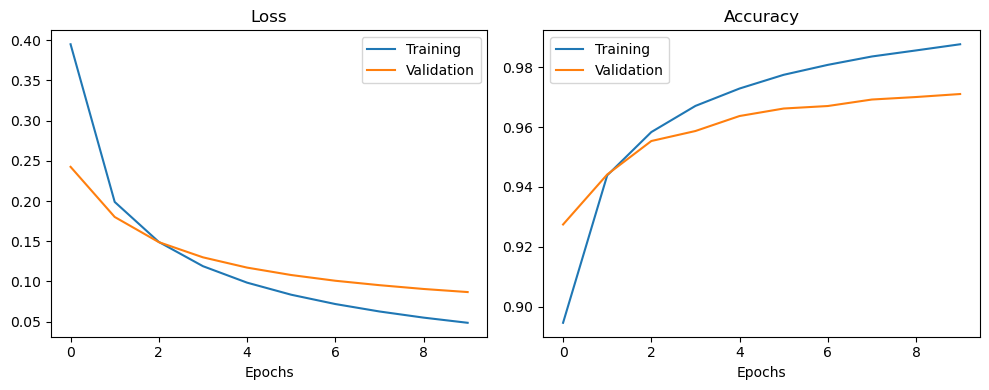

In [12]:
# plot accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_loss, label = "Training")
ax1.plot(valid_loss, label = "Validation")
ax1.legend()
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")

ax2.plot(train_acc, label = "Training")
ax2.plot(valid_acc, label = "Validation")
ax2.legend()
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")

plt.tight_layout()
plt.savefig("acc-loss.png")
plt.show()